In [1]:
import os
from dotenv import load_dotenv
from langgraph.graph.message import add_messages
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage , AnyMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import StateGraph , START , END

from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper , WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.prebuilt import ToolNode , tools_condition
from IPython.display import Image , display

In [2]:
load_dotenv()

True

In [3]:
arxiv_wrapper = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=arxiv_wrapper)

In [4]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [5]:
wiki_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [6]:
wiki.invoke("Attention is all you need")

'Page: Attention Is All You Need\nSummary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi'

In [7]:
tavily = TavilySearchResults()

C:\Users\mg735\AppData\Local\Temp\ipykernel_11432\2290291758.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("Attention is all you need")

[{'title': 'Attention Is All You Need - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Attention_Is_All_You_Need',
  'content': '"Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer "Transformer (machine learning model)"), based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a [...] 1. ^ a b c d e f Vaswani, Ashish; Shazeer, Noam; Parmar, Niki; Uszkoreit, Jakob; Jones, Llion; Gomez, Aidan N; Kaiser, Łukasz; Polosukhin, Illia (December 2017). "Attention is All you Need" (PDF). In I. Guyon and U. Von Luxburg and S. Bengio and H. Wallach and R. Fergus and S. Vishwanathan and R. Garnett (ed.). 31st Conference on Neural Information Processing S

In [9]:
tools_list = [arxiv,wiki,tavily]

In [10]:
llm = ChatGroq(
    model = "openai/gpt-oss-120b",
    temperature=0
)

llm_with_tools = llm.bind_tools(tools_list)

In [11]:
res = llm_with_tools.invoke([HumanMessage(content="What is recent ai news ?")])

In [12]:
res.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'AI news December 2025'},
  'id': 'fc_796bb62f-f051-4320-98a7-5fd02c29349d',
  'type': 'tool_call'}]

In [13]:
res

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "What is recent ai news ?" They want recent AI news. Need to provide up-to-date information. As of current date 2025-12-13. Need to browse recent AI news. Use search tool. Probably use tavily_search_results_json for news. Let\'s search query "latest AI news December 2025".', 'tool_calls': [{'id': 'fc_796bb62f-f051-4320-98a7-5fd02c29349d', 'function': {'arguments': '{"query":"AI news December 2025"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 291, 'total_tokens': 398, 'completion_time': 0.241662309, 'completion_tokens_details': {'reasoning_tokens': 71}, 'prompt_time': 0.012257679, 'prompt_tokens_details': None, 'queue_time': 0.038752535, 'total_time': 0.253919988}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_ef479defa8', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': Non

In [14]:
class State (TypedDict) : 
    messages : Annotated[list[AnyMessage],add_messages]


In [15]:
def llm_node (state:State) : 
    return {"messages" : [llm_with_tools.invoke(state['messages'])]}

In [31]:
graph = StateGraph(State)

graph.add_node("llm_node", llm_node)
graph.add_node("tools", ToolNode(tools_list))

graph.add_edge(START, "llm_node")
graph.add_conditional_edges(
    "llm_node",
    tools_condition,   # function
    {
        "tools": "tools",
        "__end__": END
    }
) 
# for Basic Agent ...
#graph.add_edge("tools", END)
# for ReAct Agent ...
graph.add_edge("tools", "llm_node")


memory = MemorySaver()
graph = graph.compile(checkpointer=memory)


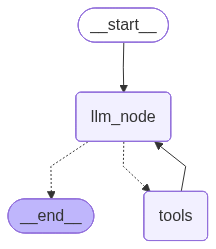

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
config = {"configurable":{"thread_id" : "1"}}

In [34]:
messages = graph.invoke({"messages" : HumanMessage(content="1706.03762")},config=config)
for m in messages['messages'] : 
    pprint(m.pretty_print())

================================ Human Message =================================

1706.03762
None
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_f1828abb-3273-4a0e-b207-c5ff85cebf97)
 Call ID: fc_f1828abb-3273-4a0e-b207-c5ff85cebf97
  Args:
    query: 1706.03762
None
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base
None
================================== Ai Message ============================

In [35]:
messages = graph.invoke({"messages" : HumanMessage(content="what is the company behind it ?")},config=config)
for m in messages['messages'] : 
    pprint(m.pretty_print())

================================ Human Message =================================

1706.03762
None
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_f1828abb-3273-4a0e-b207-c5ff85cebf97)
 Call ID: fc_f1828abb-3273-4a0e-b207-c5ff85cebf97
  Args:
    query: 1706.03762
None
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base
None
================================== Ai Message ============================